### **股票翻倍期估值**
----
* 参考集思录Fittler银行股轮动思路
* 假定公司不分红，净资产收益率不变，每年的收益利滚利，达到股价两倍所需要的时间。在EXCEL表中用函数:LOG(市净率两倍，净资产收益率+1)，翻倍期越小越好
* 以沪深300指数成分股为股票池

In [38]:
import tushare as ts
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import datetime as dt

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


In [22]:
# 日期及调整格式
today = dt.datetime.today()
yesterday = today - dt.timedelta(days=1)
yesterday = yesterday.strftime('%Y%m%d')

# 从tushare获取数据
pro = ts.pro_api('xxxxxxxxxxxxxxxxxxxx')
# 每日基本数据，含pe_ttm、pb等
df_daily_basic = pro.daily_basic(ts_code='', trade_date=yesterday, fields='ts_code,trade_date,close,pe_ttm,pb')
# 股票名称、行业
df_stock_basic = pro.stock_basic(fields='ts_code,name,industry')
# 沪深300成分股
df_hs300 = pro.index_weight(index_code='399300.SZ')
df_hs300 = df_hs300.head(300)['con_code'].tolist()

# 合并数据
df = pd.merge(df_daily_basic, df_stock_basic, how='inner')
df.set_index('ts_code', inplace=True)
df = df.reindex(df_hs300)

# 计算翻倍期double
df.dropna(how='any', inplace=True)
df['roe'] = df['pb'] / df['pe_ttm']
# 此处计算以任意数为底的log，需进行换底计算
df['double'] = np.log(df['pb'] * 2) / np.log(df['roe'] + 1)
# 以翻倍期double升序排列
df = df.sort_values('double', ascending=True)
df = df[['name', 'industry', 'close', 'pe_ttm', 'pb', 'roe', 'double', 'trade_date']]

# 计算行业数据，取平均值
df_indstry = df.groupby('industry').mean().sort_values('double', ascending=True)


- 换底公式 $$ log_b{\large a}=\frac{log \large a}{log \large b} $$

In [23]:
# 将数据按行业分类输出到excel
output_dir = './data_output/stock_' + yesterday + '.xlsx'
writer = pd.ExcelWriter(output_dir, engine='openpyxl')

df.to_excel(writer, sheet_name='所有数据')
df_indstry.to_excel(writer, sheet_name='行业数据')

stock_industry = df_indstry.index

for industry in stock_industry:
    df[df['industry'] == industry].to_excel(writer, sheet_name=industry)

writer.save()
writer.close()
    

- DataFrame.to_excel多次写入不同Sheet

* 主要需要pd.ExcelWriter([文件路径])方法 

* 参考官方文档：

```
writer = pd.ExcelWriter('output.xlsx', engine='openpyxl')
df1.to_excel(writer,'Sheet1')
df2.to_excel(writer,'Sheet2')
writer.save()
writer.close()
```

 * 注意的要点：ExcelWriter的engine参数选openpyxl，否则新版本xlsx或者老版本的xls文件会出现无法反复写入不同sheet的问题

----
- 获取数据后，开始分析

In [24]:
df.describe()

,close,pe_ttm,pb,roe,double
count,284.000000,284.000000,284.000000,284.000000,284.000000
mean,23.021796,28.598692,2.813270,0.128493,17.587611
std,55.901706,40.191657,2.639305,0.076390,25.908290
min,1.620000,5.235700,0.598900,0.004521,1.756473
25%,6.862500,12.040500,1.214300,0.067647,8.413872
50%,11.800000,19.579450,1.865350,0.119546,12.347122
75%,23.242500,33.247925,3.530875,0.169480,18.953396
max,858.810000,529.060100,18.657900,0.411988,346.998823


In [25]:
df.head()

,name,industry,close,pe_ttm,pb,roe,double,trade_date
ts_code,,,,,,,,
600015.SH,华夏银行,银行,7.52,5.5341,0.5989,0.108220,1.756473,20190509
600016.SH,民生银行,银行,6.12,5.2357,0.6275,0.119850,2.006587,20190509
000898.SZ,鞍钢股份,普钢,5.03,5.3682,0.6944,0.129354,2.699964,20190509
601328.SH,交通银行,银行,6.00,5.9721,0.6763,0.113243,2.815394,20190509
600000.SH,浦发银行,银行,11.12,5.6209,0.7116,0.126599,2.960554,20190509


- 行业情况

In [26]:
df_indstry.head()

,close,pe_ttm,pb,roe,double
industry,,,,,
银行,9.862381,6.578086,0.865424,0.130351,4.083675
矿物制品,17.860000,7.317300,2.409700,0.329315,5.524579
水泥,20.660000,8.146400,1.284500,0.175871,5.937117
区域地产,23.960000,7.812467,2.181333,0.283855,5.943620
全国地产,12.351250,8.320175,1.297750,0.161176,5.983192


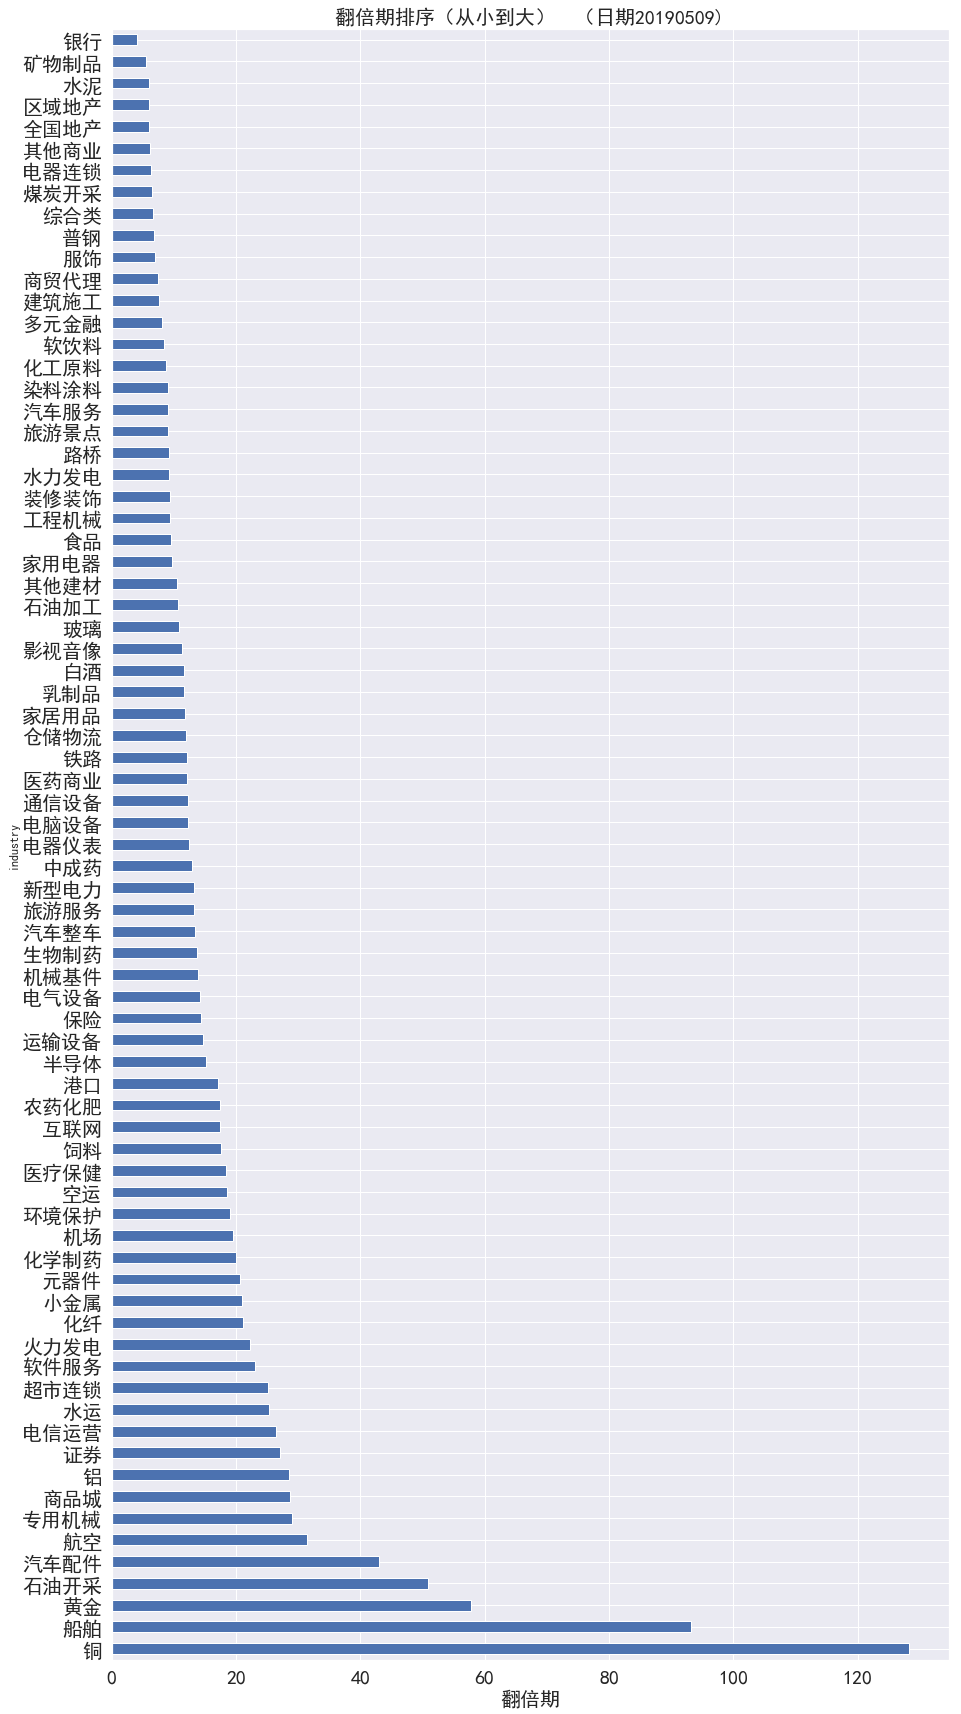

In [39]:
df_new = df_indstry.sort_values('double', ascending=False)
df_new['double'].plot(kind='barh', figsize=(15, 30), fontsize=20)
plt.title('翻倍期排序（从小到大）  ' + '（日期' + yesterday + ')', fontsize=20)
plt.xlabel('翻倍期', fontsize=20)
plt.show()

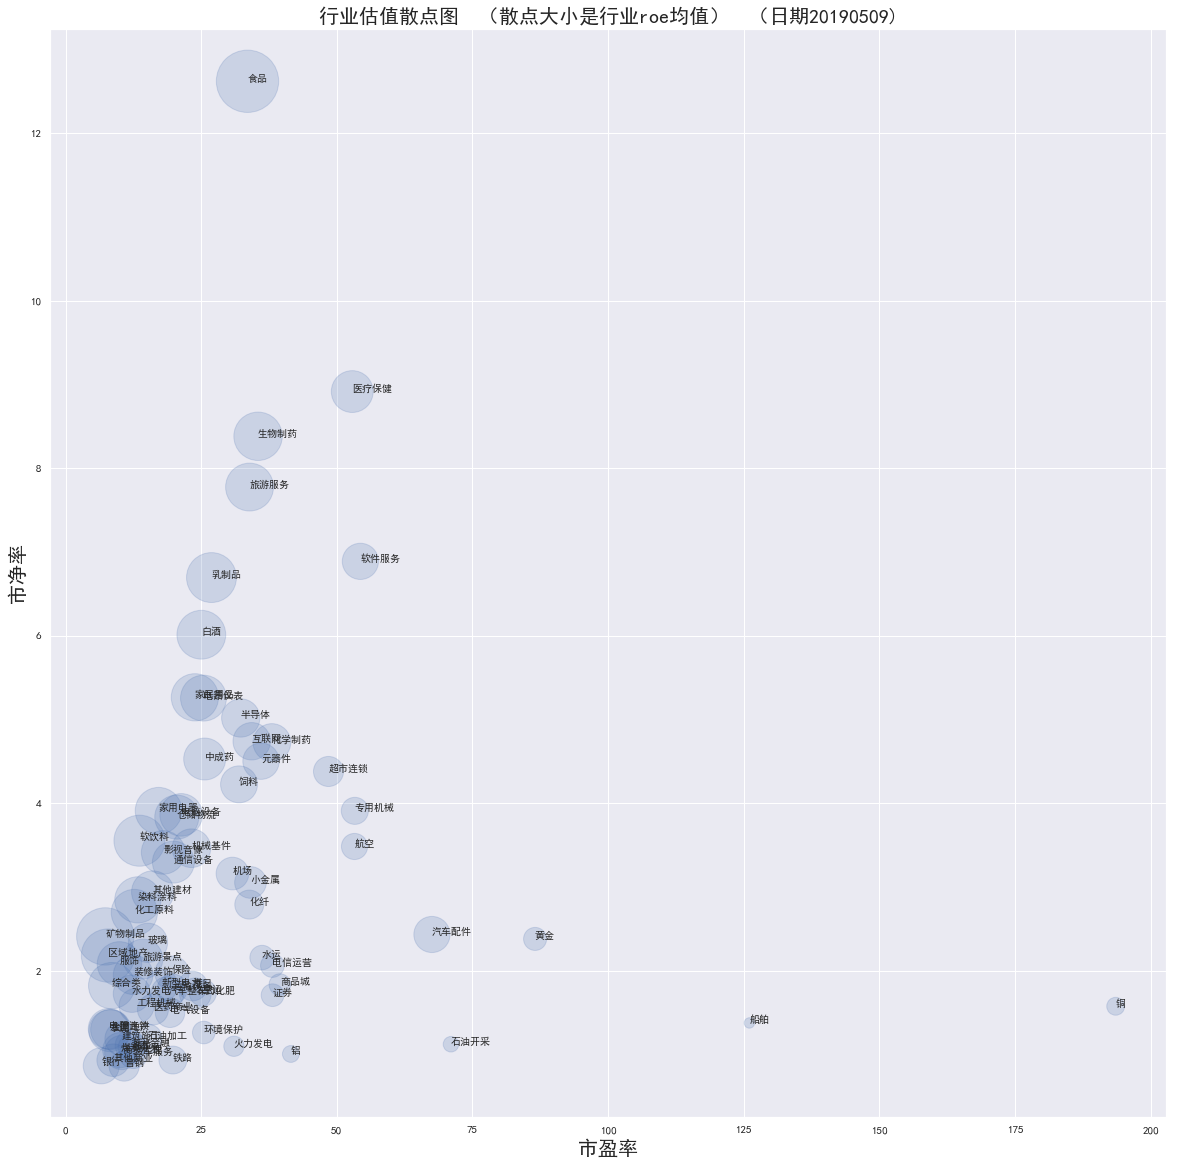

In [40]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)

name = df_indstry.index.tolist()
x = df_indstry['pe_ttm']
y = df_indstry['pb']
s = df_indstry['roe']
ax.scatter(x=x, y=y, s=s * 10000, alpha=0.2)


for i, txt in enumerate(name):
    ax.annotate(txt, (x[i], y[i]) )
    
plt.grid(True)
plt.title('行业估值散点图  （散点大小是行业roe均值）  ' + '（日期' + yesterday + ')', fontsize=20)
plt.xlabel('市盈率', fontsize=20)
plt.ylabel('市净率', fontsize=20)
plt.show()